In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import theano
import theano.tensor as T
import lasagne as L

from IPython import display

from util import *
from rosenbrock import RosenbrockFunction_Tensor

Using gpu device 1: Tesla K40m (CNMeM is disabled, cuDNN 5105)


In [2]:
%run ../lstm_optimizer_params.py
%run ../ntm_bfgs_optimizer_params.py
%run ../chain_optimizer.py

In [3]:
#A = T.scalar()
#B = T.scalar()
A = T.vector('A')
B = T.vector('B')

func = lambda theta, A, B: RosenbrockFunction_Tensor(theta, A, B).func

In [4]:
options = {
    'num_units': 20,
    'function': func,
    'n_layers': 2,
    'preprocess_input': False,
    'gradient_steps': 20,
    'gradient_clipping': 1,
    'loglr': True,
}

In [5]:
def sample_point(ndim=2, *args):
    return np.zeros(2)

def sample_point_second_phase(ndim=2, a=None, b=None):
    return np.array([a, a**2]) + 0.01 * np.random.uniform(low=-1, high=1, size=2)

def sample_params(ndim=None, *args):
    a = np.random.uniform(low=-3, high=3)
    b = np.random.uniform(20, 100)
    return a, b

def sample_point_and_params(ndim=None, sample_point=sample_point):#_second_phase):
    a, b = sample_params(ndim)
    theta = sample_point(ndim, a, b)
    
    return theta, (a, b)

def grid_sampler(low, high, num=100):
    d = (high - low) / num
    x = np.linspace(low, high, num)
    y = np.linspace(low, high, num)
    xv, yv = np.meshgrid(x, y)
    return [(np.array([xv[i, j], yv[i, j]]), sample_params()) for i in range(num) for j in range(num)]

def grid_sampler_2(n_functions, dx, dy, num=100):
    problems = []
    for _ in range(n_functions):
        a, b = sample_params()
        x = np.linspace(a - dx, a + dx, num)
        y = np.linspace(a**2 - dy, a**2 + dy, num)
        xv, yv = np.meshgrid(x, y)
        problems += [(np.array([xv[i, j], yv[i, j]]), a, b) for i in range(num) for j in range(num)]
    return list(map(np.array, zip(*problems)))

def multisampler(n, *args):
    A = np.random.uniform(low=-3, high=3, size=n)
    B = np.random.uniform(20, 100, size=n)
    theta = np.zeros((n, 2))
    return theta, A, B

In [6]:
_thetas = []
_as = []
_bs = []

for d in [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]:
    _theta, _a, _b = grid_sampler_2(100, d, d, 20)
    
    _thetas.append(_theta)
    _as.append(_a)
    _bs.append(_b)

train_inputs = np.concatenate(_thetas), np.concatenate(_as), np.concatenate(_bs)

Time compiling value_fn: 0.34271883964538574


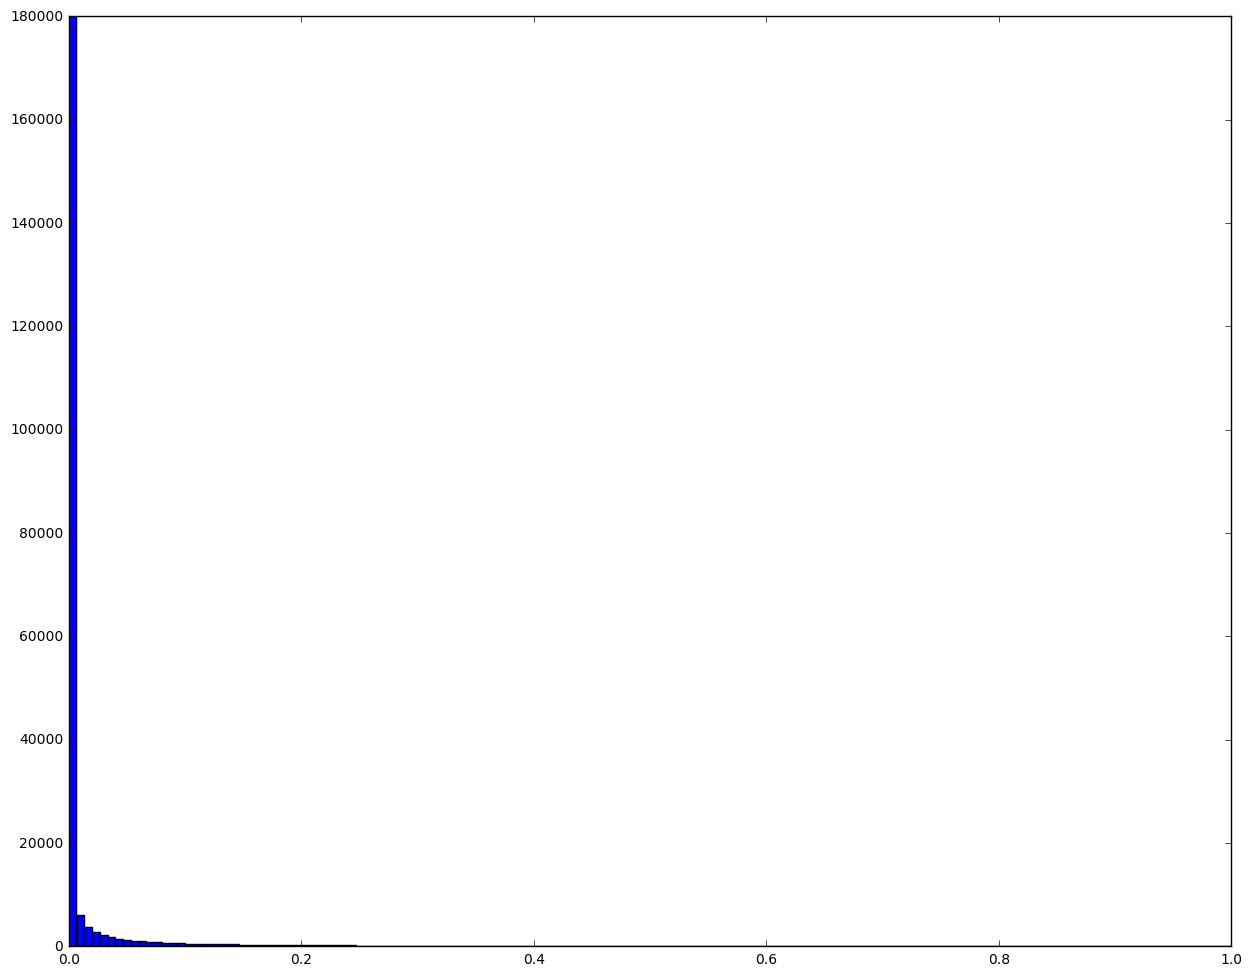

In [7]:
opt = LSTM_Optimizer(params_input=[A, B], **options)
opt.prepare_value_fn()

values = opt.value_fn(*train_inputs)
plt.figure(figsize=(15, 12))
plt.hist(values[values < 1], bins=150);

In [8]:
partition = get_partition(train_inputs, values, [1e2, 1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10])
len(partition)

8

In [9]:
new_partition = []

for p in partition:
    print(len(p[0]))
    indices = np.arange(len(p[0]))
    np.random.shuffle(indices)
    
    new_partition.append((p[0][indices][:12000], p[1][indices][:12000], p[2][indices][:12000]))

19309
38136
39104
38771
41009
37942
43700
22029


In [11]:
options['n_gac'] = 0
n_opt = 10

lstm_opts = [LSTM_Optimizer(scale_output=2**(-i), params_input=[A, B], **options) for i in range(n_opt)]
lstm_chain_opt = ChainOptimizer(lstm_opts, n_small_steps=20)

ntm_opts = [NTM_BFGS_Optimizer(scale_output=2**(-i), params_input=[A, B], **options) for i in range(n_opt)]
ntm_chain_opt = ChainOptimizer(ntm_opts, n_small_steps=20)

In [ ]:
lstm_chain_opt.prepare(loss_type='sum', start_lr=0.001)
ntm_chain_opt.prepare(loss_type='sum', start_lr=0.001)

Time compiling value_fn: 0.10929393768310547
Time compiling loss_fn: 3.711296319961548
Time compiling train_fn: 94.11495471000671
Time compiling value_fn: 0.12357735633850098
Time compiling loss_fn: 3.1492068767547607
Time compiling train_fn: 99.22440505027771
Time compiling value_fn: 0.0972602367401123
Time compiling loss_fn: 2.827241897583008
Time compiling train_fn: 91.04688453674316


In [12]:
val_inputs = multisampler(8000)

In [13]:
n_epochs   = 30
batch_size = 400

training_options = {
    'n_epochs'  : n_epochs,
    'batch_size': batch_size,
    'decay_rate': 1.0,
    'verbose': True
}

iterations = [20]
n_functions = n_epochs * batch_size

In [ ]:
training_options['n_iter'] = 20
    
losses = {}
for opt, name in [(lstm_chain_opt, 'LSTM'), (ntm_chain_opt, 'NTM')]:
    print("Training {}:".format(name))
    losses[name] = []
    
    for j in range(n_opt):
        opt.opts[j].lr.set_value(0.005)
        opt.opts[j].reset_network()

        opt_loss, val_loss = opt.opts[j].train(new_partition[j], val_inputs, **training_options)
        losses[name].append((opt_loss, val_loss))

In [ ]:
print("Training {}:".format('NTM'))
losses['NTM'] = []

for j in range(n_opt):
    ntm_chain_opt.opts[j].lr.set_value(0.005)
    ntm_chain_opt.opts[j].reset_network()

    opt_loss, val_loss = ntm_chain_opt.opts[j].train(new_partition[j], val_inputs, **training_options)
    losses['NTM'].append((opt_loss, val_loss))

Training NTM:
Epoch number 0
	Time: 6.7748565673828125
	Optimizer loss: 17231.886635416664
	Median final loss: 2.484889030456543
	Validation loss: 112.3079384765625
Epoch number 1
	Time: 6.576075315475464
	Optimizer loss: 1534.8791432291664
	Median final loss: 0.4268302321434021
	Validation loss: 35.60466247558594
Epoch number 2
	Time: 6.732795715332031
	Optimizer loss: 1147.6132760416667
	Median final loss: 0.670181393623352
	Validation loss: 36.74488647460937
Epoch number 3
	Time: 6.689216375350952
	Optimizer loss: 1110.2031614583332
	Median final loss: 0.2626952826976776
	Validation loss: 45.51234448242186
Epoch number 4
	Time: 6.37172269821167
	Optimizer loss: 1022.3770677083331
	Median final loss: 0.04356980323791504
	Validation loss: 54.58024658203125
Epoch number 5
	Time: 6.736667156219482
	Optimizer loss: 938.0419505208334
	Median final loss: 0.05935679376125336
	Validation loss: 54.44588964843749
Epoch number 6
	Time: 6.622556447982788
	Optimizer loss: 929.1174010416665
	Media

IndexError: list index out of range

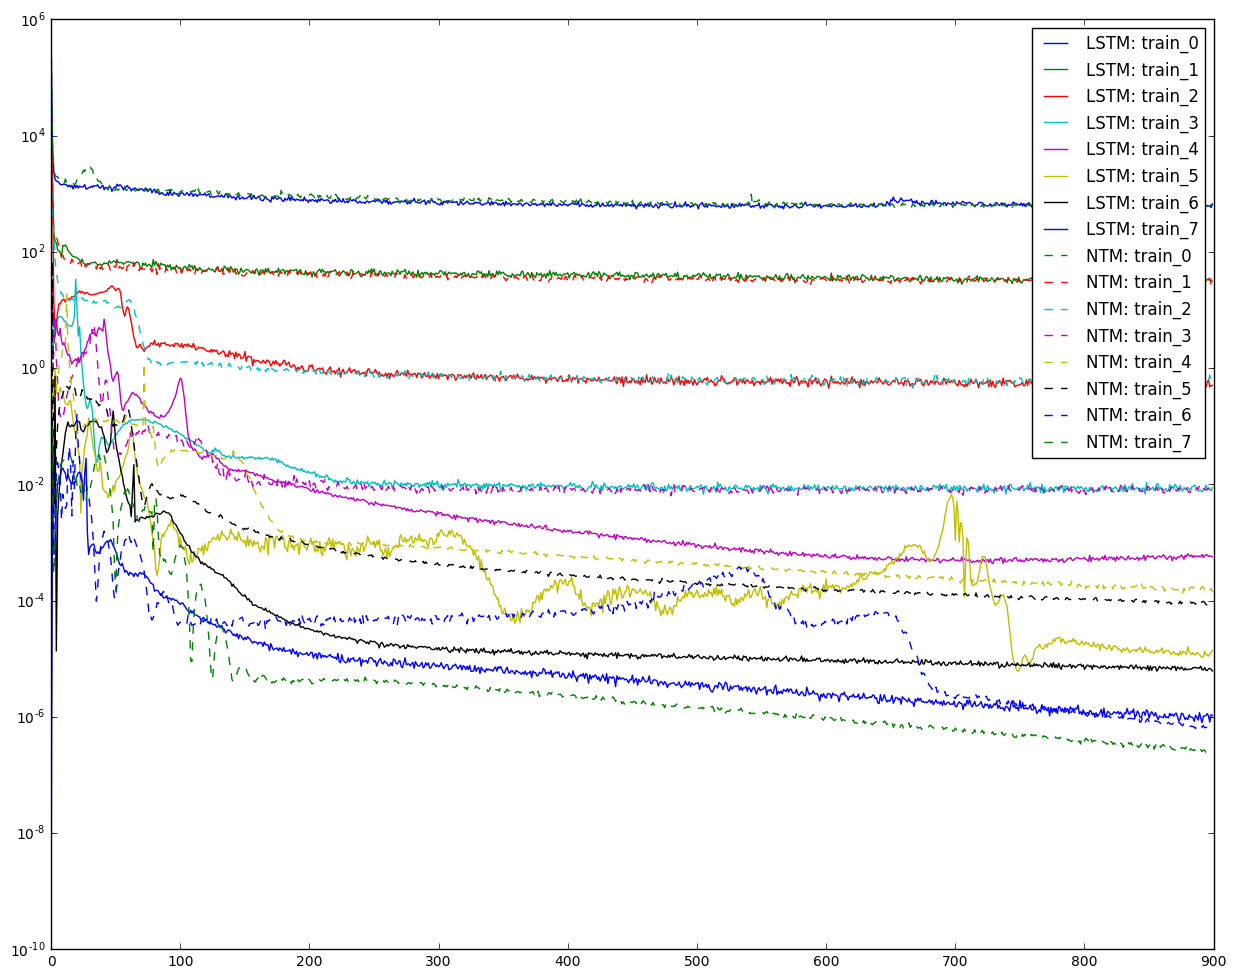

In [28]:
plt.figure(figsize=(15, 12))
for name, opt_losses in losses.items():
    for k, (train_loss, val_loss) in enumerate(opt_losses):
        linestyle = 'solid' if name == 'LSTM' else '--'
        plt.semilogy(train_loss, label='{}: train_{}'.format(name, k), linestyle=linestyle)
#         plt.semilogy(np.arange(len(val_loss)) * 20, val_loss, label='val_{}'.format(name))
plt.legend();

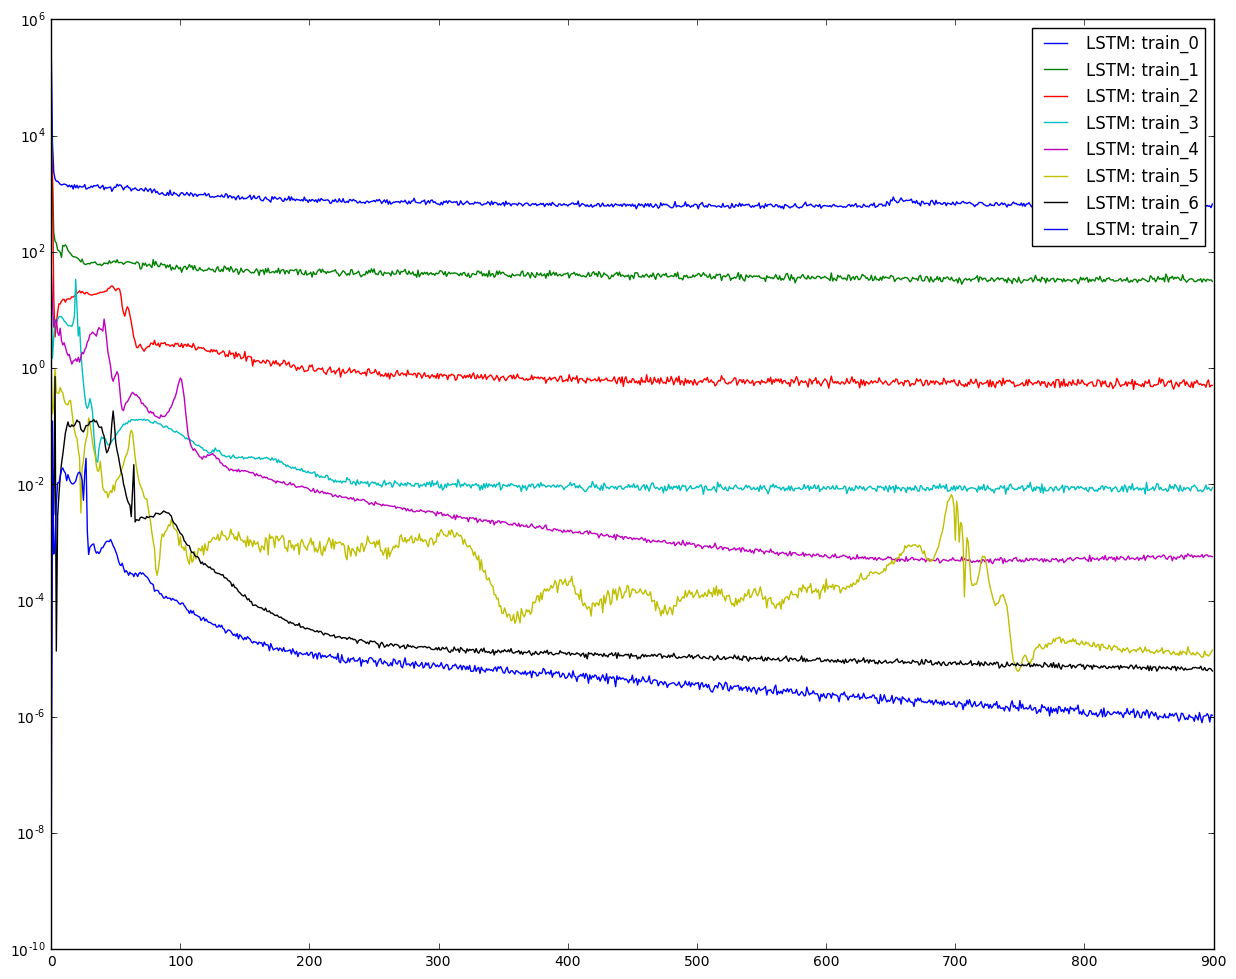

In [20]:
plt.figure(figsize=(15, 12))
for name, opt_losses in losses.items():
    for k, (train_loss, val_loss) in enumerate(opt_losses):
        plt.semilogy(train_loss, label='{}: train_{}'.format(name, k))
#         plt.semilogy(np.arange(len(val_loss)) * 20, val_loss, label='val_{}'.format(name))
plt.legend();

In [29]:
from rosenbrock import RosenbrockFunction

AA = T.scalar('a')
BB = T.scalar('b')
func_ = lambda theta: RosenbrockFunction(theta, AA, BB).func

sgd_fn = make_sgd(func_, var=[AA, BB])
momentum_fn = make_momentum(func_, var=[AA, BB])
lbfgs_fn = make_lbfgs(func_, m=10, init_lr=2e-4, var=[AA, BB])

non_lstm_optimizers = {
    'sgd': sgd_fn,
    'momentum': momentum_fn, 
    'lbfgs': lbfgs_fn
}

In [30]:
lstm_optimizers = {'lstm': lstm_chain_opt, 'ntm': ntm_chain_opt}

In [31]:
from collections import namedtuple
TestCase = namedtuple('TestCase', 'n_iter n_functions')

In [32]:
tests = [
    TestCase(n_iter=20, n_functions=50), 
    TestCase(n_iter=60, n_functions=50),
    TestCase(n_iter=500, n_functions=50),
    TestCase(n_iter=500, n_functions=1)
]

tests_results = []

for n_iter, n_functions in tests:
    testing_options = {
        'n_iter'     : n_iter,
        'n_functions': n_functions,
        'sampler'    : multisampler,
        'normalize': True
    }
    histories = test_optimizers(lstm_optimizers, non_lstm_optimizers, **testing_options)
    tests_results.append(histories)

Testing lstm; lstm
Testing lstm; ntm
Testing sgd
Testing lbfgs
Testing momentum
Testing lstm; lstm
Testing lstm; ntm
Testing sgd
Testing lbfgs
Testing momentum
Testing lstm; lstm
Testing lstm; ntm
Testing sgd
Testing lbfgs
Testing momentum
Testing lstm; lstm
Testing lstm; ntm
Testing sgd
Testing lbfgs
Testing momentum


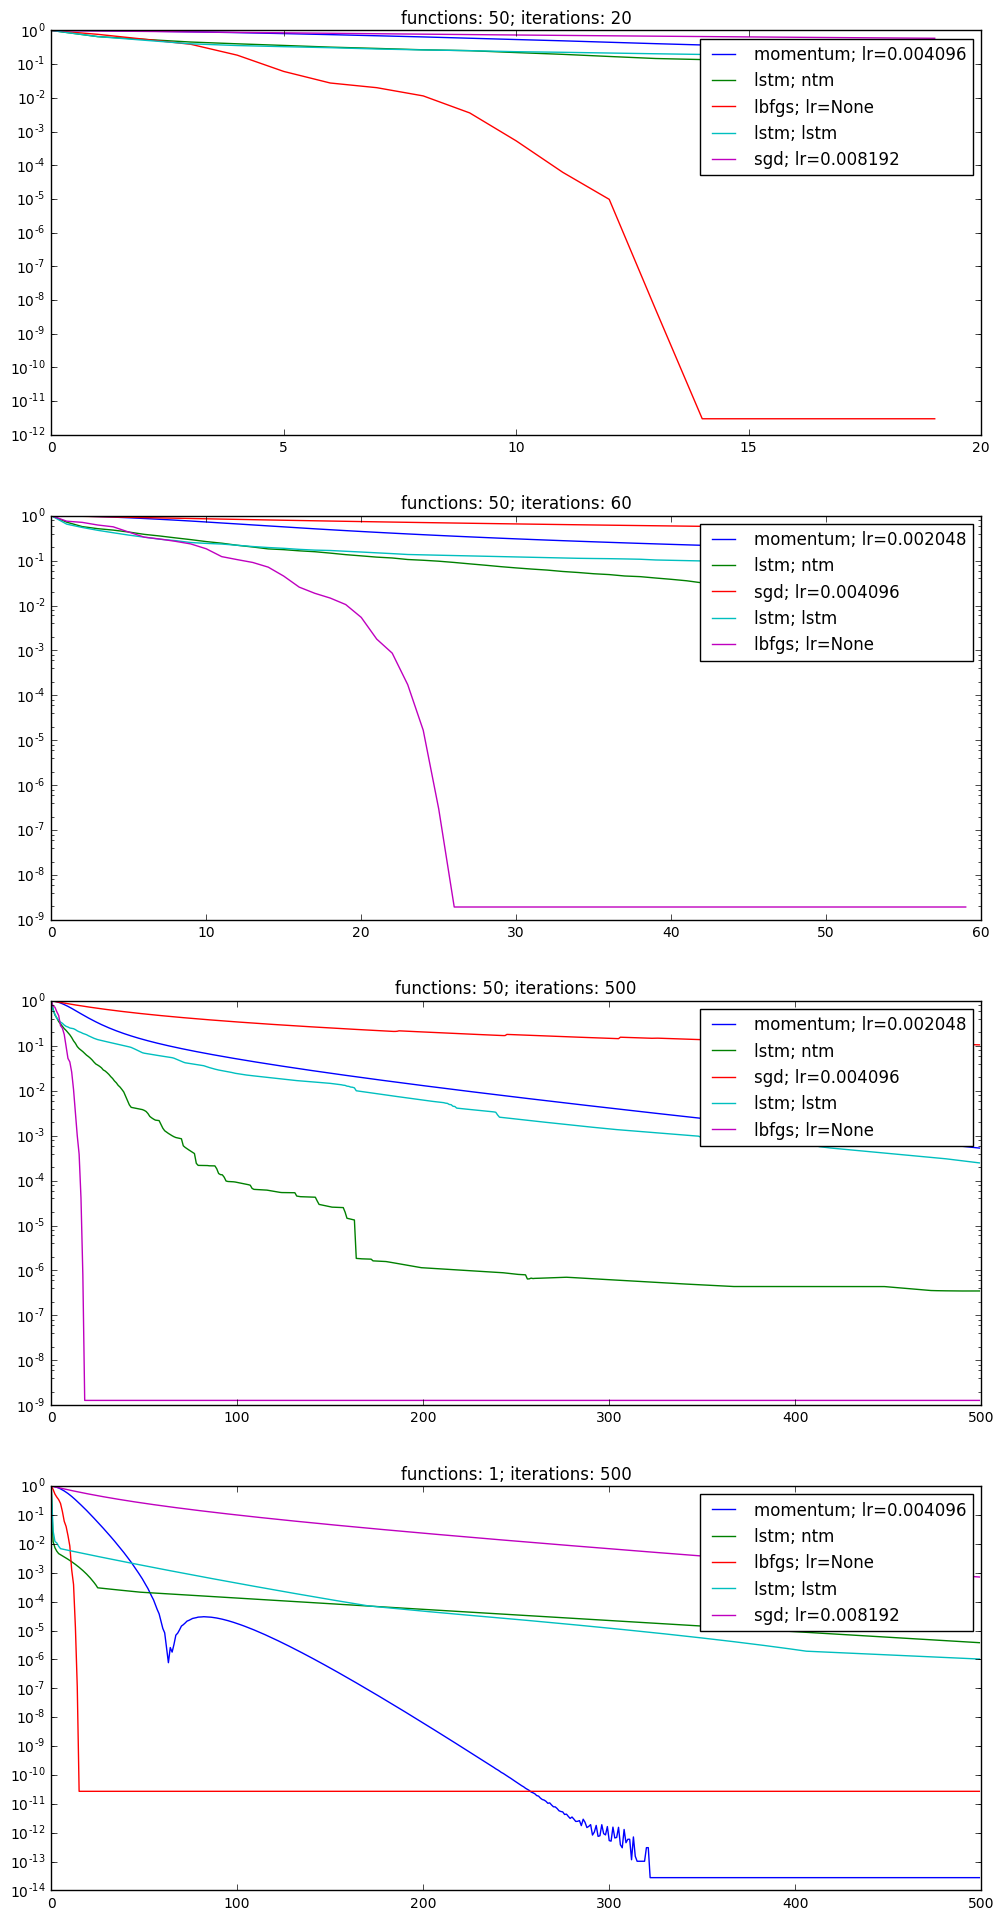

In [33]:
%matplotlib inline
fig, axes = plt.subplots(len(tests_results), figsize=(12, 6 * len(tests_results)))

if len(tests_results) == 1:
    axes = (axes,)

for ax, (n_iter, n_functions), h in zip(axes, tests, tests_results):
    for name, hist in h.items():
        ax.semilogy(hist, label=name)
    
    ax.set_title('functions: {}; iterations: {}'.format(n_functions, n_iter))
    ax.legend()
    
# fig.tight_layout()

(-0.32029592504536986, 0.10258947960066918)


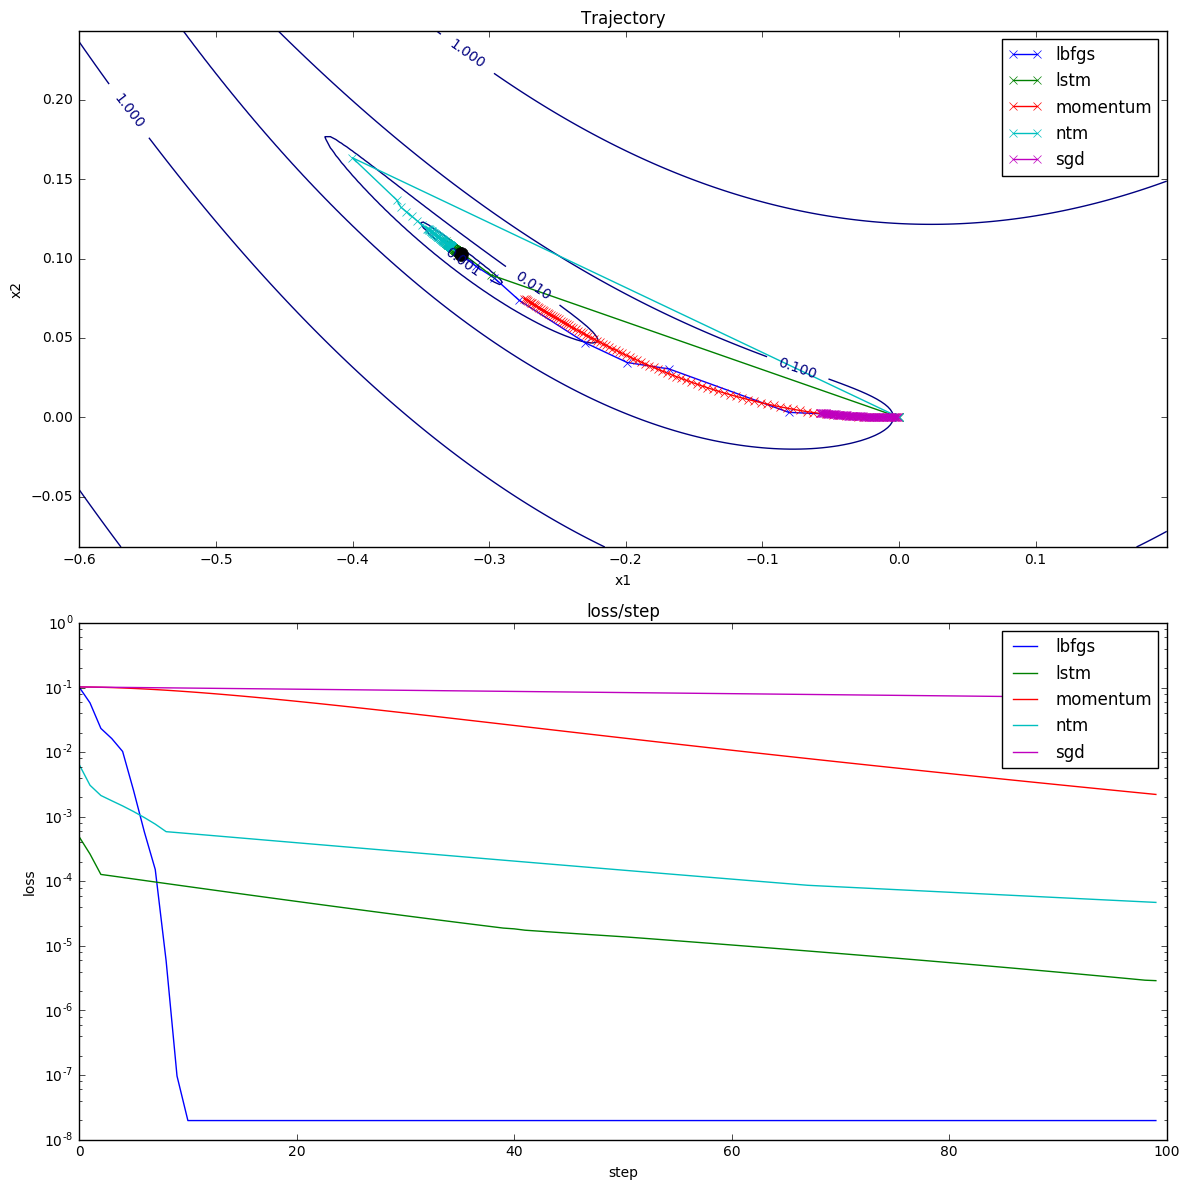

In [34]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point), lstm_optimizers, non_lstm_optimizers)

(-2.1884127548994456, 4.789150385806582)


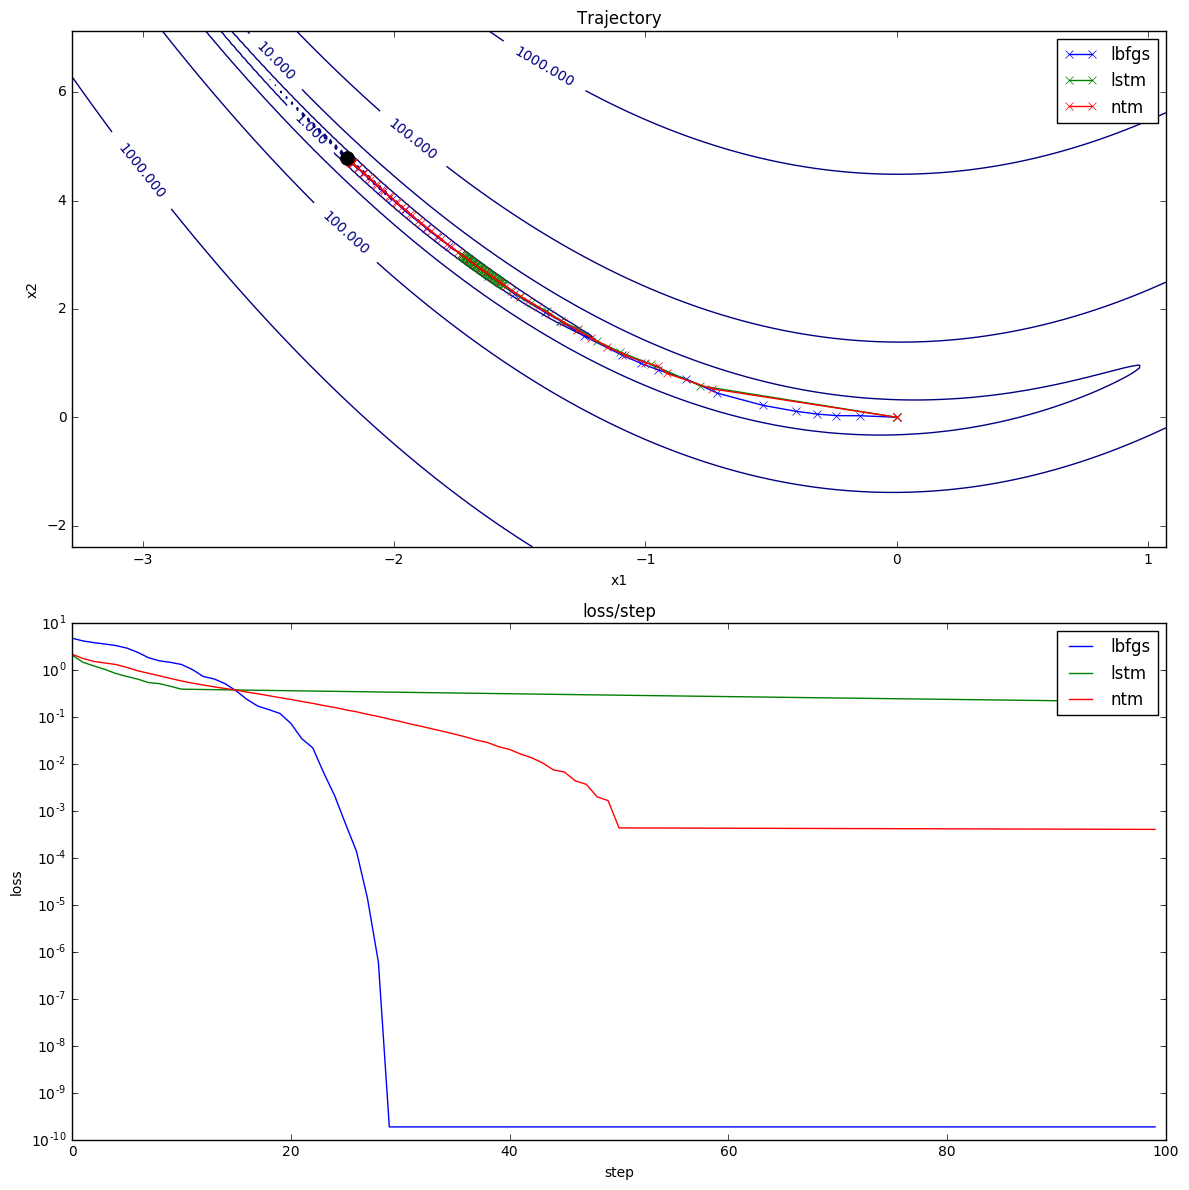

In [ ]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point), lstm_optimizers, {k: v for k, v in non_lstm_optimizers.items() if k == 'lbfgs'})

In [ ]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point_second_phase), lstm_optimizers, non_lstm_optimizers)

In [ ]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point_second_phase), lstm_optimizers, {k: v for k, v in non_lstm_optimizers.items() if k == 'lbfgs'})